# Data science is OSEMN

According to a popular model, the elements of data science are

* Obtaining data
* Scrubbing data
* Exploring data
* Modeling data
* iNterpreting data

and hence the acronym OSEMN, pronounced as “Awesome”.

We will start with the **O**, moving towards the rest later, but first let's have a quick look at what it all boils down to:

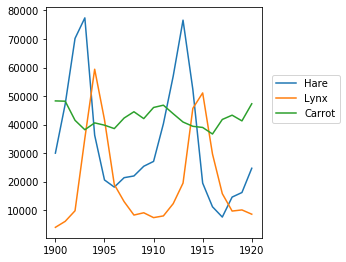

In [1]:
import numpy as np
data = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = data.T # trick: columns to variables


from matplotlib import pyplot as plt
%matplotlib inline

plt.axes([0.2, 0.1, 0.5, 0.8]) 
plt.plot(year, hares, year, lynxes, year, carrots) 
plt.legend(('Hare', 'Lynx', 'Carrot'), loc=(1.05, 0.5)) 

By plotting the data a clear (and reasonable) correlations between pray and predator becomes evident. How can it be quantified? Is that statistical significant? What about the correlation between carrots and hares? Is that evident? Is that significant?

Finding correlations in data is the main goal of data science, though that is not the end of the story: as this precious [site](http://tylervigen.com/spurious-correlations) demonstrates, **correlations is not causation**. 


*Exercise*: write an algorithm that determins and quantifies a correlation between two time series. Use as an example the hare-lynx-carrot dataset.

# Obtaining and processing (remote) data

Accessing data is a really serious business. Data can sit on public or on remote machines. In the case of the former, things may be straightforward, whereas in the latter case you need to worry about a few things.

In both cases, depending on the size of the dataset, the managment of the dataset can become extremely complicated. We won't deal here with large datasets, which require a whole course per se.., but still care should be put. In particular, it is not wise to keep (and even worse commit) data into a git repository!

The suggestion is then to create a directory somewhere and copy the example datasets there. From a terminal:

```bash

# create a data directory in your home directory
mkdir ~/data/

# check the content (it's empty now of course)
ls -ltr ~/data/

# in the case you need to move there:
cd ~/data/
```

### Download data from a server

A nice set of interesting datasets can be found on this [server](https://archive.ics.uci.edu/ml/datasets.html?sort=nameUp&view=list) that collects training/test data for machine learning developments. Several of those pertein physical sciences, it is worth browsing through those.

You can download any of those, in the following we will consider a dataset from the MAGIC experiment. For that we will the `wget` command

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/    

In [ ]:
# print the description. This can (and better) be done from a terminal
!cat ~/data/magic04.names

It is possible to download and load remote files via their url's directly from within python (and thus on a jupyter session). This is a rather powerful tool as it allows http communications, IO streaming and so on.

Care should be put as the dataset is stored in memory.

In [2]:
import urllib.request
url ='https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names'
with urllib.request.urlopen(url) as data_file:
    #print (data_file.read(300))
    for line in data_file:
        print (line)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1056)>

###  Copy data from a remote machine

Often datasets are not available on websites but rather they are sitting on some remote machine. Several tools are there that can allow you to get hold off remote data, even from within python (e.g. [paramiko](https://www.paramiko.org/)), but best in this case is to get a local copy. E.g. from a terminal:

```bash
scp guest104@gatep.fisica.unipd.it:~/data/data_000637.* ~/data/
```

by issuing that command you are immediately exposed to the most relevant problem in obtaining the data: permissions/authorization.

Secondily (essentially a further consequence of the same issue), the remote machine itself may have accessibility restrictions, e.g. being behind a firewall. In that case you may need to use a tunnel:

``` bash
ssh -L 1234:<address of R known to G>:22 <user at G>@<address of G> 

scp -P 1234 <user at R>@127.0.0.1:/path/to/file file-name-to-be-copied
```

In summary, just getting the data is a complicated business.

## Data Formats

datasets can be stored in a gazillion different ways, often they have formats which are application dependent, even though more and more standards are being established. Python have "readers" for most of the formats, another reason for being the optimal programming language for data analysis.

### Text files 

Plain text files are commonly used for "readibility", at the price of a very poor storing efficiency due to their low entropy. [UTF-8](https://en.wikipedia.org/wiki/UTF-8) is the most common encoding.

Reading (and writing) text files in python is straightforward:

In [3]:
file_name = "/Users/mzanetti/data/magic04.data"

# mode can be specified for writing, reading or both
with open(file_name, mode='r') as f:
    # print-out the whole file
    # print (f.read()) 
    for line in f:
        ## print line by line
        print (line)
        ## each line is a string, you need to split it yourself
        # for c in line.split(): print(c) # check the functionalities of the split() method 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mzanetti/data/magic04.data'

### CSV files

If you are lucky text files are already framed into a defined structured, in a "table-like" manner. These files are colled "comma separated values" (csv), even though the separator may well not be the "," symbol.
Python have package to deal with that:

In [ ]:
import csv

with open('/Users/mzanetti/data/magic04.data') as data_file:
    for line in csv.reader(data_file, delimiter=','): # the delimiter is often guessed by the reader
        # again note that elements of each line are treated as strings
        # if you need to convert them into numbers, you need to to that yourself
        fLength,fWidth,fSize,\
        fConc,fConc1,fAsym,\
        fM3Long,fM3Trans,fAlpha,fDist = map(float,line[:-1])
        category = line[-1]
        print (fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist)
        print (category)
        break

More often than not, csv files have comments (e.g. starting with '#'), which cannot be interpreted by the reader. Tricks like:

```python
csv.reader(row for row in f if not row.startswith('#'))
```

may be useful

## Binary (hexadecimal) files

The output of sensors often is stored as hexadecimal files. Information is packed in a well defined format (similarly to how floating point numbers are formatted).
To read and process hexadecimal files in python you need to use the "b" option of `open` and progress along the file at step of defined lenght (depending on the size of the words information is packed into)

The following is an example from data collected from an FPGA implementing a TDC. Relevant infomation are the coordinates of the TDC channels and their time measurements.

In [2]:
import struct, time

with  open('/Users/mzanetti/data/data_000637.dat','rb') as file:
    file_content=file.read()
    word_counter=0
    word_size = 8 # size of the word in bytes
    for i in range(0, len(file_content), word_size):
        word_counter+=1
        if word_counter>100: break
        time.sleep(0.1)
        thisInt = struct.unpack('<q', file_content[i:i+word_size])[0]
        head = (thisInt >> 62) & 0x3
        if head == 1:
            fpga     = (thisInt >> 58) & 0xF
            tdc_chan = (thisInt >> 49) & 0x1FF
            orb_cnt  = (thisInt >> 17) & 0xFFFFFFFF
            bx       = (thisInt >> 5 ) & 0xFFF
            tdc_meas = (thisInt >> 0 ) & 0x1F
            if i==0 : print ('{0},{1},{2},{3},{4},{5}'.format('HEAD', 'FPGA', 'TDC_CHANNEL', 'ORB_CNT', 'BX', 'TDC_MEAS'))
            print ('{0},{1},{2},{3},{4},{5}'.format(head, fpga, tdc_chan, orb_cnt, bx, tdc_meas))
        else:
            print ('ERROR! head =', head)



FileNotFoundError: [Errno 2] No such file or directory: 'data_000637.dat'

### JSON files

JSON is JavaScript Object Notation - a format used widely for web-based resource sharing. It is very similar in structure to a Python nested dictionary. Here is an example from http://json.org/example

In [3]:
%%file example.json
{
    "glossary": {
        "title": "example glossary",
            "GlossDiv": {
            "title": "S",
                    "GlossList": {
                "GlossEntry": {
                    "ID": "SGML",
                                    "SortAs": "SGML",
                                    "GlossTerm": "Standard Generalized Markup Language",
                                    "Acronym": "SGML",
                                    "Abbrev": "ISO 8879:1986",
                                    "GlossDef": {
                        "para": "A meta-markup language, used to create markup languages such as DocBook.",
                                            "GlossSeeAlso": ["GML", "XML"]
                    },
                                    "GlossSee": "markup"
                }
            }
        }
    }
}

Writing example.json


In [4]:
!cat example.json

{
    "glossary": {
        "title": "example glossary",
            "GlossDiv": {
            "title": "S",
                    "GlossList": {
                "GlossEntry": {
                    "ID": "SGML",
                                    "SortAs": "SGML",
                                    "GlossTerm": "Standard Generalized Markup Language",
                                    "Acronym": "SGML",
                                    "Abbrev": "ISO 8879:1986",
                                    "GlossDef": {
                        "para": "A meta-markup language, used to create markup languages such as DocBook.",
                                            "GlossSeeAlso": ["GML", "XML"]
                    },
                                    "GlossSee": "markup"
                }
            }
        }
    }
}


In [5]:
import json
data = json.load(open('example.json'))
print (data)

{'glossary': {'title': 'example glossary', 'GlossDiv': {'title': 'S', 'GlossList': {'GlossEntry': {'ID': 'SGML', 'SortAs': 'SGML', 'GlossTerm': 'Standard Generalized Markup Language', 'Acronym': 'SGML', 'Abbrev': 'ISO 8879:1986', 'GlossDef': {'para': 'A meta-markup language, used to create markup languages such as DocBook.', 'GlossSeeAlso': ['GML', 'XML']}, 'GlossSee': 'markup'}}}}}


In [6]:
# and can be parsed using standard key lookups
data['glossary']['GlossDiv']['GlossList']

{'GlossEntry': {'ID': 'SGML',
  'SortAs': 'SGML',
  'GlossTerm': 'Standard Generalized Markup Language',
  'Acronym': 'SGML',
  'Abbrev': 'ISO 8879:1986',
  'GlossDef': {'para': 'A meta-markup language, used to create markup languages such as DocBook.',
   'GlossSeeAlso': ['GML', 'XML']},
  'GlossSee': 'markup'}}

### HDF5

HDF5 is a hierarchical format often used to store complex scientific data. For instance, Matlab now saves its data to HDF5. It is particularly useful to store complex hierarchical data sets with associated metadata, for example, the results of a computer simulation experiment.

The main concepts associated with HDF5 are

* file: container for hierachical data - serves as ‘root’ for tree
* group: a node for a tree
* dataset: array for numeric data - can be huge
* attribute: small pieces of metadata that provide additional context

Now let's create a dummy dataset

In [7]:
import numpy as np
import h5py

#Now mock up some simple dummy data to save to our file.
d1 = np.random.random(size = (1000,20))
d2 = np.random.random(size = (1000,200))

print (d1.shape, d2.shape)


hf = h5py.File('data.h5', 'w')
hf.create_dataset('dataset_1', data=d1)
hf.create_dataset('dataset_2', data=d2)
hf.close()

ModuleNotFoundError: No module named 'h5py'

and read it

In [8]:
hf = h5py.File('data.h5', 'r')

print (hf.keys())

n1 = hf.get('dataset_1')
print (n1)

n1 = np.array(n1)
print (n1.shape)

NameError: name 'h5py' is not defined

here is another example

In [9]:
import h5py
import numpy as np
import os

# creating a HDF5 file
import datetime

if not os.path.exists('example.hdf5'):

    with h5py.File('example.hdf5') as f:
        project = f.create_group('project')
        expt1 = project.create_group('expt1')
        expt2 = project.create_group('expt2')
        expt1.create_dataset('counts', (100,), dtype='i')
        expt2.create_dataset('values', (1000,), dtype='f')

        expt1['counts'][:] = range(100)
        expt2['values'][:] = np.random.random(1000)

ModuleNotFoundError: No module named 'h5py'

In [ ]:
with h5py.File('example.hdf5') as f:
    project = f['project']
    print (project['expt1']['counts'][:10])
    print (project['expt2']['values'][:10])

### Pandas

the most convenient tool to read and process formatted dataset is however Pandas. In the following a couple of examples. Pandas will be the main subject of one of the next classes


In [10]:
import pandas as pd
file_name="/Users/mzanetti/data/LEMMA2018/DT/raw/data_000636.txt"
data=pd.read_csv(file_name,nrows=10,skiprows=range(1,1))
data

FileNotFoundError: [Errno 2] File b'/Users/mzanetti/data/LEMMA2018/DT/raw/data_000636.txt' does not exist: b'/Users/mzanetti/data/LEMMA2018/DT/raw/data_000636.txt'

In [ ]:
import pandas as pd
file_name="/Users/mzanetti/data/magic04.data"
data=pd.read_csv(file_name,nrows=1000)
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']
data

In [ ]:
%matplotlib inline

data.plot.scatter("fLength","fWidth",)


In [ ]:
data.hist("fAlpha")